In [1]:
import cached
import cpr_gym
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

tqdm.pandas()
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-136-g0ddea92-dirty
cpr_lib_version: v0.7.0-136-g0ddea92-dirty


In [2]:
episode_len = 2048
n_episodes = 100
batches = [
    # "2023-01-18_all-protos-0",
    # "2023-01-19_nakamoto-0",
    # "2023-01-19_all-protos-0",
    # "2023-01-20_tailstorm-0",
    # "2023-01-20_tailstorm-discount",
    # "2023-01-23_non-discount-low-alpha",
    # "2023-01-25_bk-8-long-0",  # not so long since I forgot to push the changes before launch
    # "2023-01-25_tailstorm-discount-0",
    # "2023-02-01-alpha50",
    "2023-02-21_ent_coef",
    "2023-03-10_full",
    "2023-03-17_learning-rate",
    "2023-03-21_learning-rate",
]

protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)

env_name = "cpr_gym:cpr-v0"


def env_kwargs_of_row(x):
    return dict(
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )

# Data generation

## Find trained models

In [3]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            protocol = frag.pop(1)

            ent_coef = 0
            for i, x in enumerate(frag):
                if x.startswith("entcoef"):
                    ent_coef = float(x.removeprefix("entcoef"))
                    frag.pop(i)

            learning_rate = "linear:1e-3"
            for i, x in enumerate(frag):
                if x.startswith("lr"):
                    learning_rate = x.removeprefix("lr")
                    frag.pop(i)

            shape = "raw"
            for i, x in enumerate(frag):
                if x in ["raw", "exp", "cut"]:
                    shape = x
                    frag.pop(i)

            if protocol == "nakamoto":
                yield dict(
                    protocol=protocol,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["bk", "bkll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["tailstorm", "tailstormll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward=frag.pop(1),
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reuse="-")
models

protocol  k    reward subblock_selection  alpha  gamma  \
0      nakamoto  1  constant                n/a   0.45   0.95   
1     tailstorm  8  constant          heuristic   0.35   0.05   
2            bk  8  constant                n/a   0.20   0.05   
3     tailstorm  8  constant          heuristic   0.30   0.95   
4     tailstorm  8  constant          heuristic   0.20   0.50   
...         ... ..       ...                ...    ...    ...   
1262         bk  8  constant                n/a   0.20   0.05   
1263         bk  8  constant                n/a   0.20   0.95   
1264   nakamoto  1  constant                n/a   0.45   0.50   
1265         bk  8  constant                n/a   0.40   0.95   
1266  tailstorm  8  constant          heuristic   0.50   0.50   

                    batch learning_rate  ent_coef shape             policy  \
0     2023-02-21_ent_coef   linear:1e-3    0.0001   raw  ppo-6vu6b9w6-best   
1     2023-02-21_ent_coef   linear:1e-3    0.0001   raw  ppo-pia2ch4q-best   
2     2023-02-21_ent_coef   linear:1e-3    0.0100   raw  ppo-wujmdcos-best   
3     2023-02-21_ent_coef   linear:1e-3    0.0100   raw     ppo-2wq4ya3o_2   
4     2023-02-21_ent_coef   linear:1e-3    0.0010   raw     ppo-n3f08wh3_2   
...                   ...           ...       ...   ...                ...   
1262      2023-03-10_full   linear:1e-3    0.0000   raw  ppo-k6s30th5-best   
1263      2023-03-10_full   linear:1e-3    0.0000   raw  ppo-5jm2phri-best   
1264      2023-03-10_full   linear:1e-3    0.0000   raw  ppo-2h5itvxq-best   
1265      2023-03-10_full   linear:1e-3    0.0000   raw  ppo-koak2pbh-best   
1266      2023-03-10_full   linear:1e-3    0.0000   raw  ppo-742svn3v-best   

                                                   path     kind reuse  
0     data/models/2023-02-21_ent_coef/ppo-nakamoto-a...  trained     -  
1     data/models/2023-02-21_ent_coef/ppo-tailstorm-...  trained     -  
2     data/models/2023-02-21_ent_coef/ppo-bk-8-alpha...  trained     -  
3     data/models/2023-02-21_ent_coef/ppo-tailstorm-...  trained     -  
4     data/models/2023-02-21_ent_coef/ppo-tailstorm-...  trained     -  
...                                                 ...      ...   ...  
1262  data/models/2023-03-10_full/ppo-bk-8-alpha20-g...  trained     -  
1263  data/models/2023-03-10_full/ppo-bk-8-alpha20-g...  trained     -  
1264  data/models/2023-03-10_full/ppo-nakamoto-alpha...  trained     -  
1265  data/models/2023-03-10_full/ppo-bk-8-alpha40-g...  trained     -  
1266  data/models/2023-03-10_full/ppo-tailstorm-8-co...  trained     -  

[1267 rows x 14 columns]

In [4]:
# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            reuse="proto", reward="discount"
        ),
        models.query("gamma != 0.05").assign(reuse="gamma05", gamma=0.05),
        models.query("gamma != 0.50").assign(reuse="gamma50", gamma=0.50),
        models.query("gamma != 0.95").assign(reuse="gamma95", gamma=0.95),
    ]
)
models = models.assign(reused=[x != "-" for x in models.reuse])
# models

## Find hard-coded policies

In [5]:
def hard_coded_policies(models):
    for _idx, x in (
        models[["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]]
        .drop_duplicates()
        .iterrows()
    ):
        kwargs = env_kwargs_of_row(x)
        env = gym.make(env_name, **kwargs)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reuse="-", reused=False)
)
hard_coded_policies
# hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

protocol  k    reward subblock_selection  gamma  alpha  \
0     nakamoto  1  constant                n/a   0.95   0.45   
1     nakamoto  1  constant                n/a   0.95   0.45   
2     nakamoto  1  constant                n/a   0.95   0.45   
3     nakamoto  1  constant                n/a   0.95   0.45   
4    tailstorm  8  constant          heuristic   0.05   0.35   
..         ... ..       ...                ...    ...    ...   
331         bk  8  constant                n/a   0.50   0.50   
332         bk  8  constant                n/a   0.95   0.40   
333         bk  8  constant                n/a   0.95   0.40   
334         bk  8  constant                n/a   0.95   0.40   
335         bk  8  constant                n/a   0.95   0.40   

                   policy        kind path reuse  reused  
0    sapirshtein-2016-sm1  hard-coded  n/a     -   False  
1         eyal-sirer-2014  hard-coded  n/a     -   False  
2                  simple  hard-coded  n/a     -   False  
3                  honest  hard-coded  n/a     -   False  
4              avoid-loss  hard-coded  n/a     -   False  
..                    ...         ...  ...   ...     ...  
331                honest  hard-coded  n/a     -   False  
332            avoid-loss  hard-coded  n/a     -   False  
333           minor-delay  hard-coded  n/a     -   False  
334             get-ahead  hard-coded  n/a     -   False  
335                honest  hard-coded  n/a     -   False  

[336 rows x 11 columns]

## Run simulations

In [6]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)

In [7]:
def measure_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = episode_len
    kwargs["seed"] = getattr(x, "episode", None)
    if x.kind == "trained":
        with warnings.catch_warnings():
            warnings.filterwarnings(
                action="ignore", category=UserWarning, lineno=458
            )  # transition to sb3 v1.7
            res = cached.measure_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = cached.measure_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


def parallel_measure(df, fun=measure_row, n_jobs=-1):
    res = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(fun)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


episodes = parallel_measure(episodes)

# list(episodes.columns)

  0%|          | 0/447000 [00:00<?, ?it/s]

In [8]:
# save episode data for re-use in other notebooks
episodes.to_pickle("experiments/rl-eval/episodes.pkl")

# Find optimal policies

In [9]:
scenario = [
    "protocol",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
    "kind",
    "reused",
]
policy = ["policy", "path"]
# d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

protocol  k    reward subblock_selection  alpha  gamma        kind  \
0           bk  8  constant                n/a    0.2   0.05  hard-coded   
1           bk  8  constant                n/a    0.2   0.05     trained   
2           bk  8  constant                n/a    0.2   0.05     trained   
3           bk  8  constant                n/a    0.2   0.50  hard-coded   
4           bk  8  constant                n/a    0.2   0.50     trained   
..         ... ..       ...                ...    ...    ...         ...   
247  tailstorm  8  discount          heuristic    0.5   0.50     trained   
248  tailstorm  8  discount          heuristic    0.5   0.50     trained   
249  tailstorm  8  discount          heuristic    0.5   0.95  hard-coded   
250  tailstorm  8  discount          heuristic    0.5   0.95     trained   
251  tailstorm  8  discount          heuristic    0.5   0.95     trained   

     reused             policy  
0     False             honest  
1     False  ppo-ub5mebn8-best  
2      True  ppo-pmrgklqq-best  
3     False             honest  
4     False  ppo-r73btgb2-best  
..      ...                ...  
247   False  ppo-ldgcu5sl-best  
248    True  ppo-2gamo0zy-best  
249   False        minor-delay  
250   False  ppo-ijtjbhmp-best  
251    True  ppo-jlwm4xoj-best  

[252 rows x 9 columns]

# Compare RL against best hard-coded

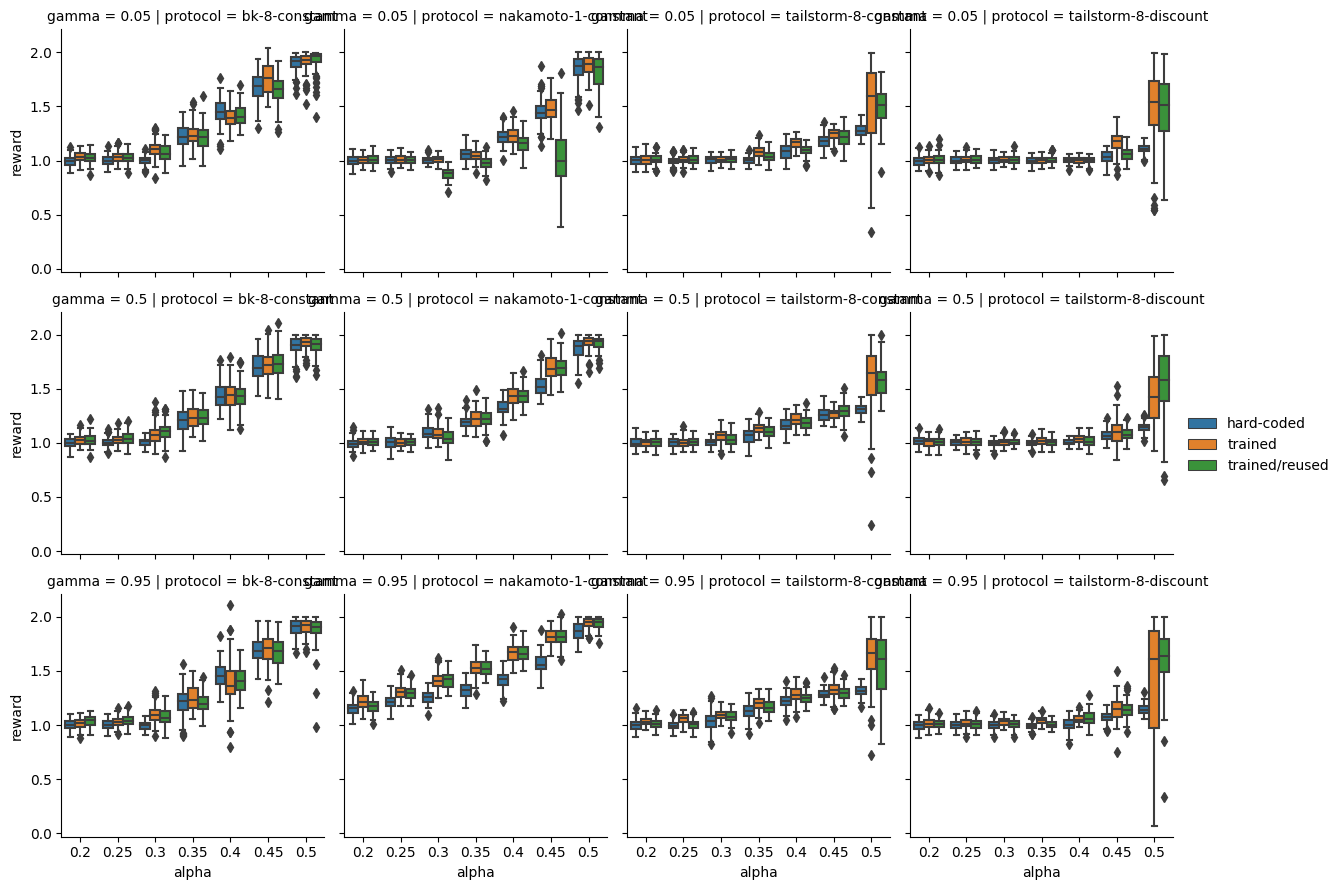

In [10]:
def rl_vs_hard_coded_bp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d,
        # data=d.query("alpha >= .35"),
        col="protocol",
        row="gamma",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette=sns.color_palette(),
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

In [11]:
opt_policies.query('protocol == "tailstorm" and gamma==0.95 and alpha==.45').drop(
    columns=["path"]
)

protocol  k    reward subblock_selection  alpha  gamma        kind  \
177  tailstorm  8  constant          heuristic   0.45   0.95  hard-coded   
178  tailstorm  8  constant          heuristic   0.45   0.95     trained   
179  tailstorm  8  constant          heuristic   0.45   0.95     trained   
240  tailstorm  8  discount          heuristic   0.45   0.95  hard-coded   
241  tailstorm  8  discount          heuristic   0.45   0.95     trained   
242  tailstorm  8  discount          heuristic   0.45   0.95     trained   

     reused             policy  
177   False        minor-delay  
178   False     ppo-ha8ook2p_2  
179    True     ppo-5r4m6xp7_2  
240   False        minor-delay  
241   False  ppo-7l4rhx8x-best  
242    True  ppo-ha8ook2p-best

/tmp/ipykernel_22908/3968487956.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  opt_episodes.groupby(


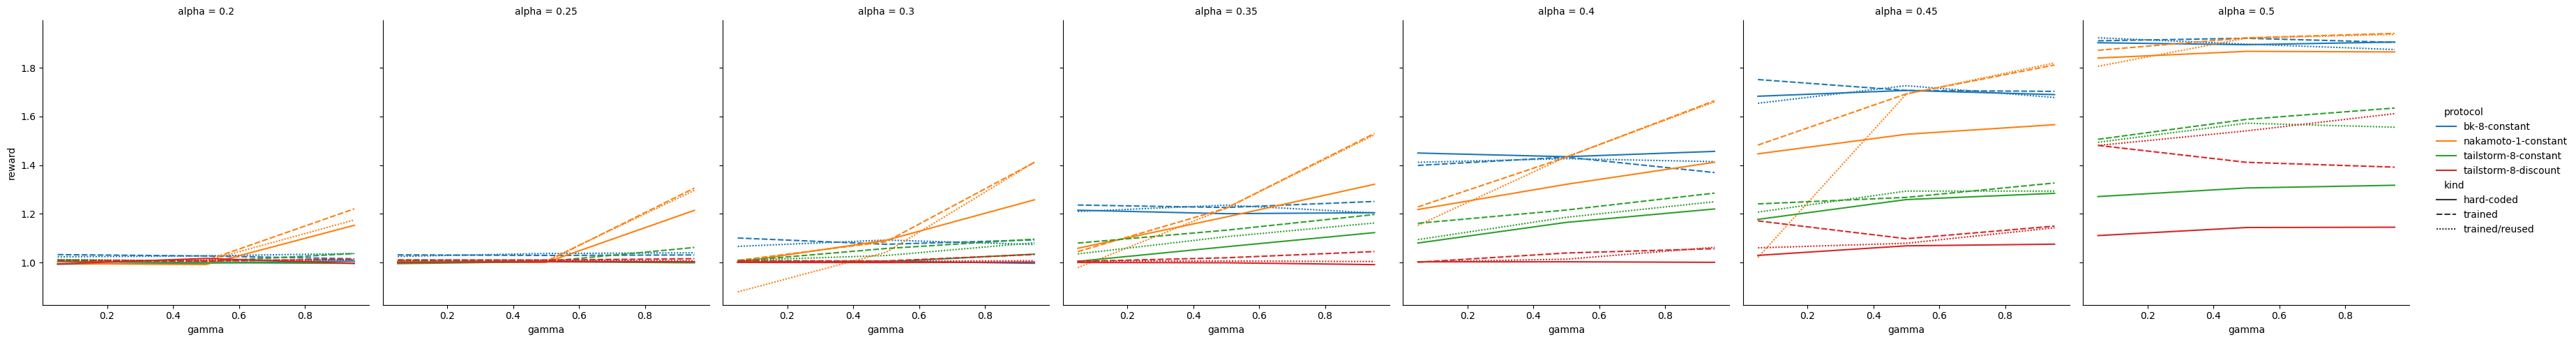

In [12]:
def rl_vs_hard_coded_gamma_lp(objective, label="reward"):
    d = (
        opt_episodes.groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )
        .mean()
        .reset_index()
    )
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="alpha",
        x="gamma",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_gamma_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

/tmp/ipykernel_22908/4159778813.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  opt_episodes.groupby(


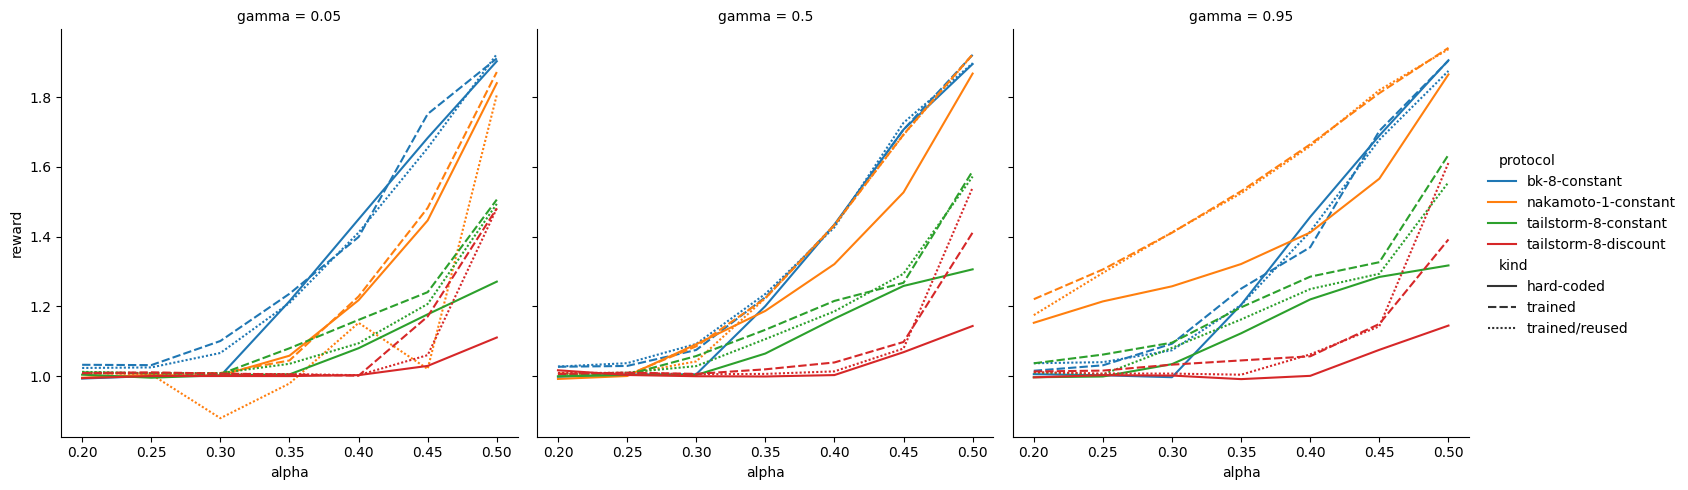

In [13]:
def rl_vs_hard_coded_alpha_lp(objective, label="reward"):
    d = (
        opt_episodes.groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )
        .mean()
        .reset_index()
    )
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="gamma",
        x="alpha",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_alpha_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

# Honest or Attack?

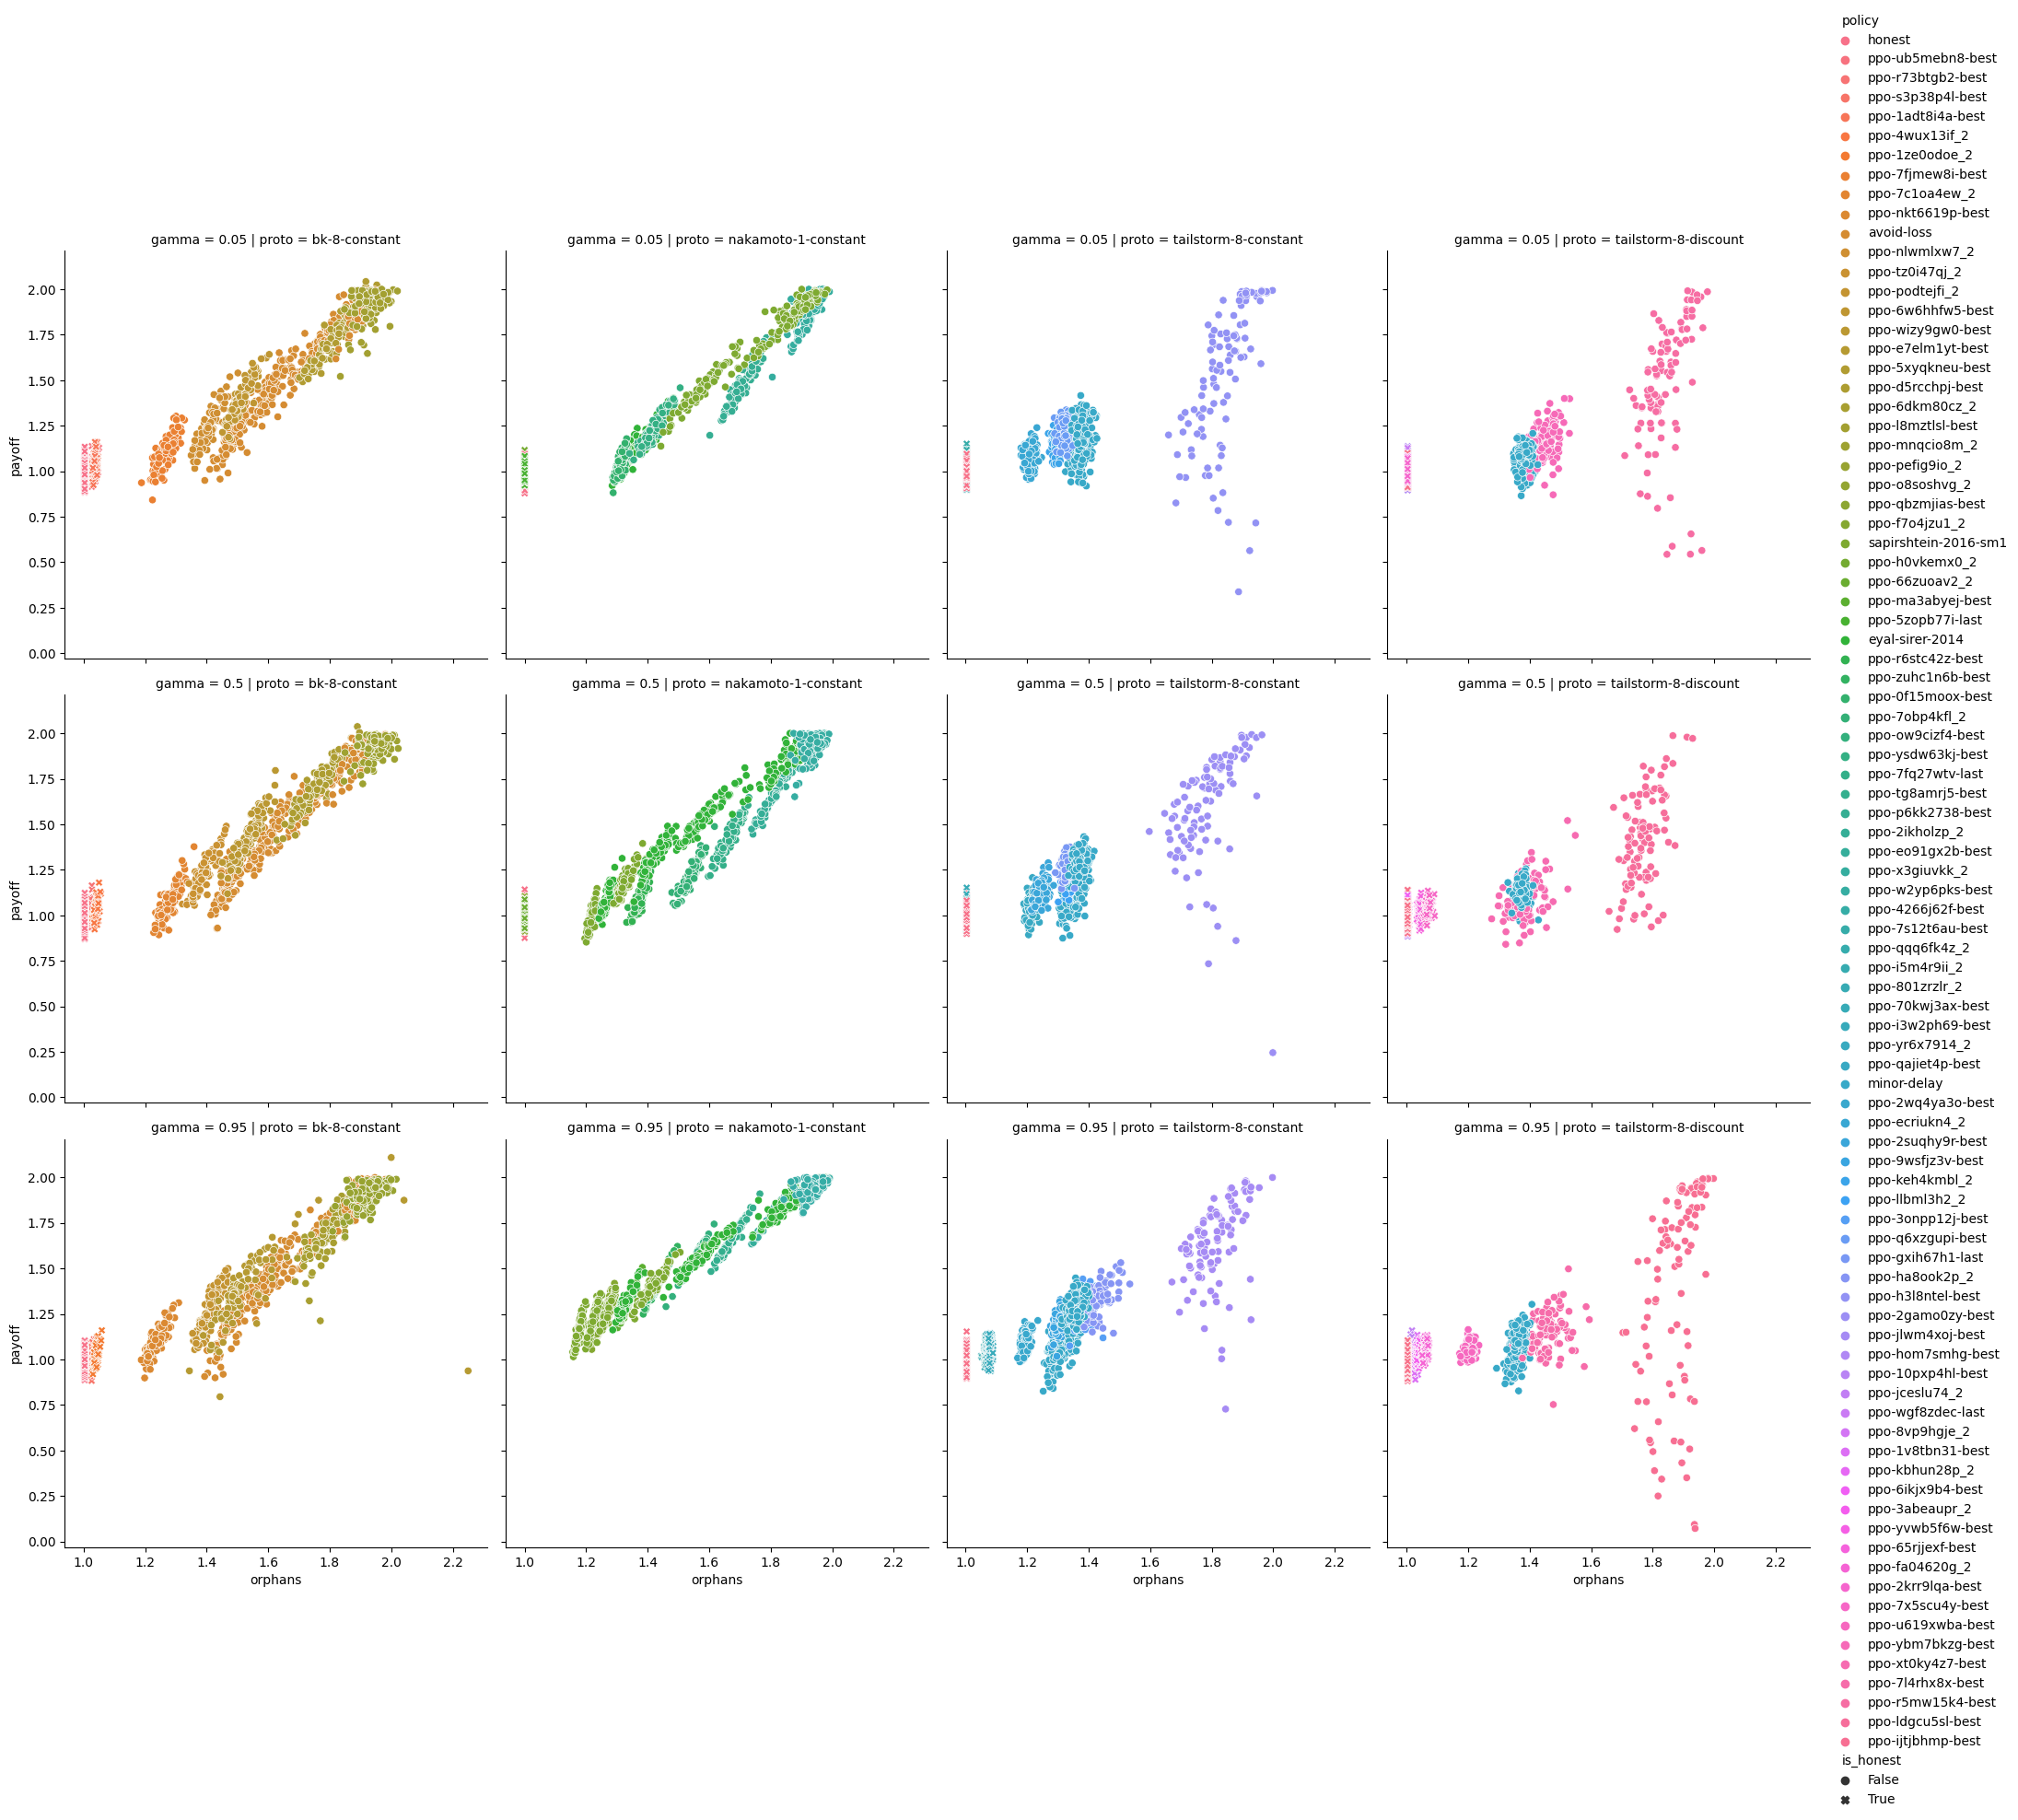

In [14]:
grouping = ["protocol", "k", "reward", "subblock_selection", "alpha", "gamma", "policy"]
d = opt_episodes.query("not reused")
d = d.assign(
    orphans=d.episode_n_activations / d.episode_progress,
    proto=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    payoff=d.episode_reward_attacker / d.episode_progress / d.alpha,
)
dd = d.groupby(grouping).agg(
    mean_orphans=("orphans", "mean"),
    mean_payoff=("payoff", "mean"),
    std_payoff=("payoff", "std"),
)
d = d.set_index(grouping + ["episode"]).join(dd).reset_index()
d = d.assign(is_honest=d.mean_orphans <= 1.15)
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="policy",
    style="is_honest",
    row="gamma",
    col="proto",
)
honest_or_attack_episodes = d  # for later use
# list(d.columns)

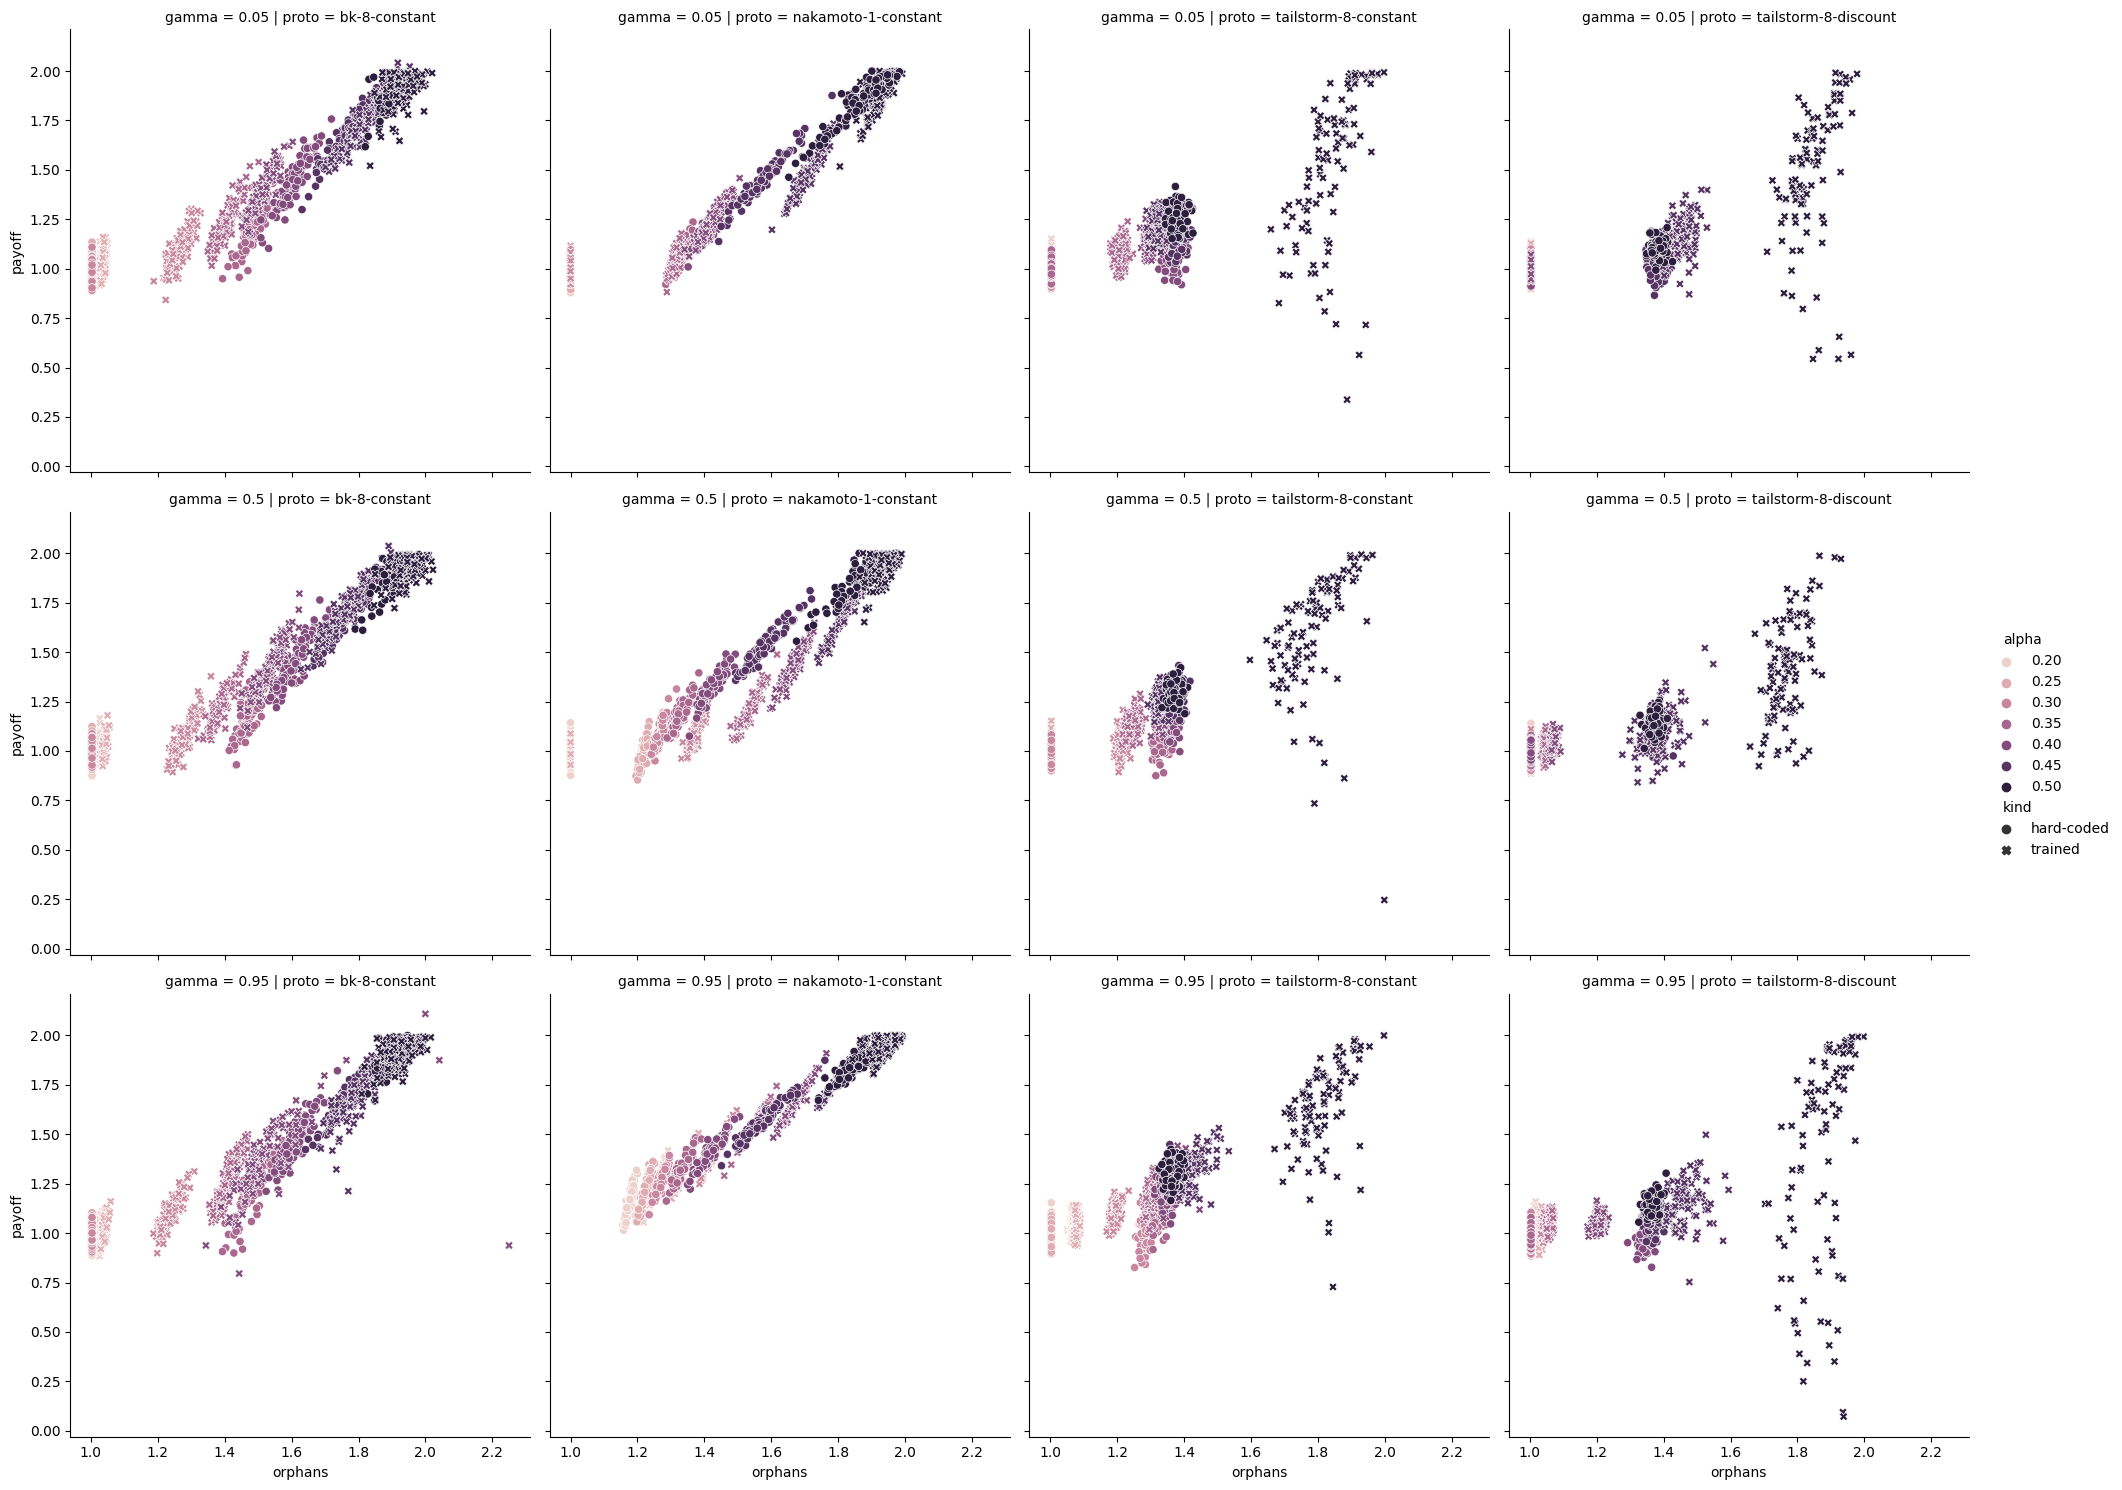

In [15]:
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

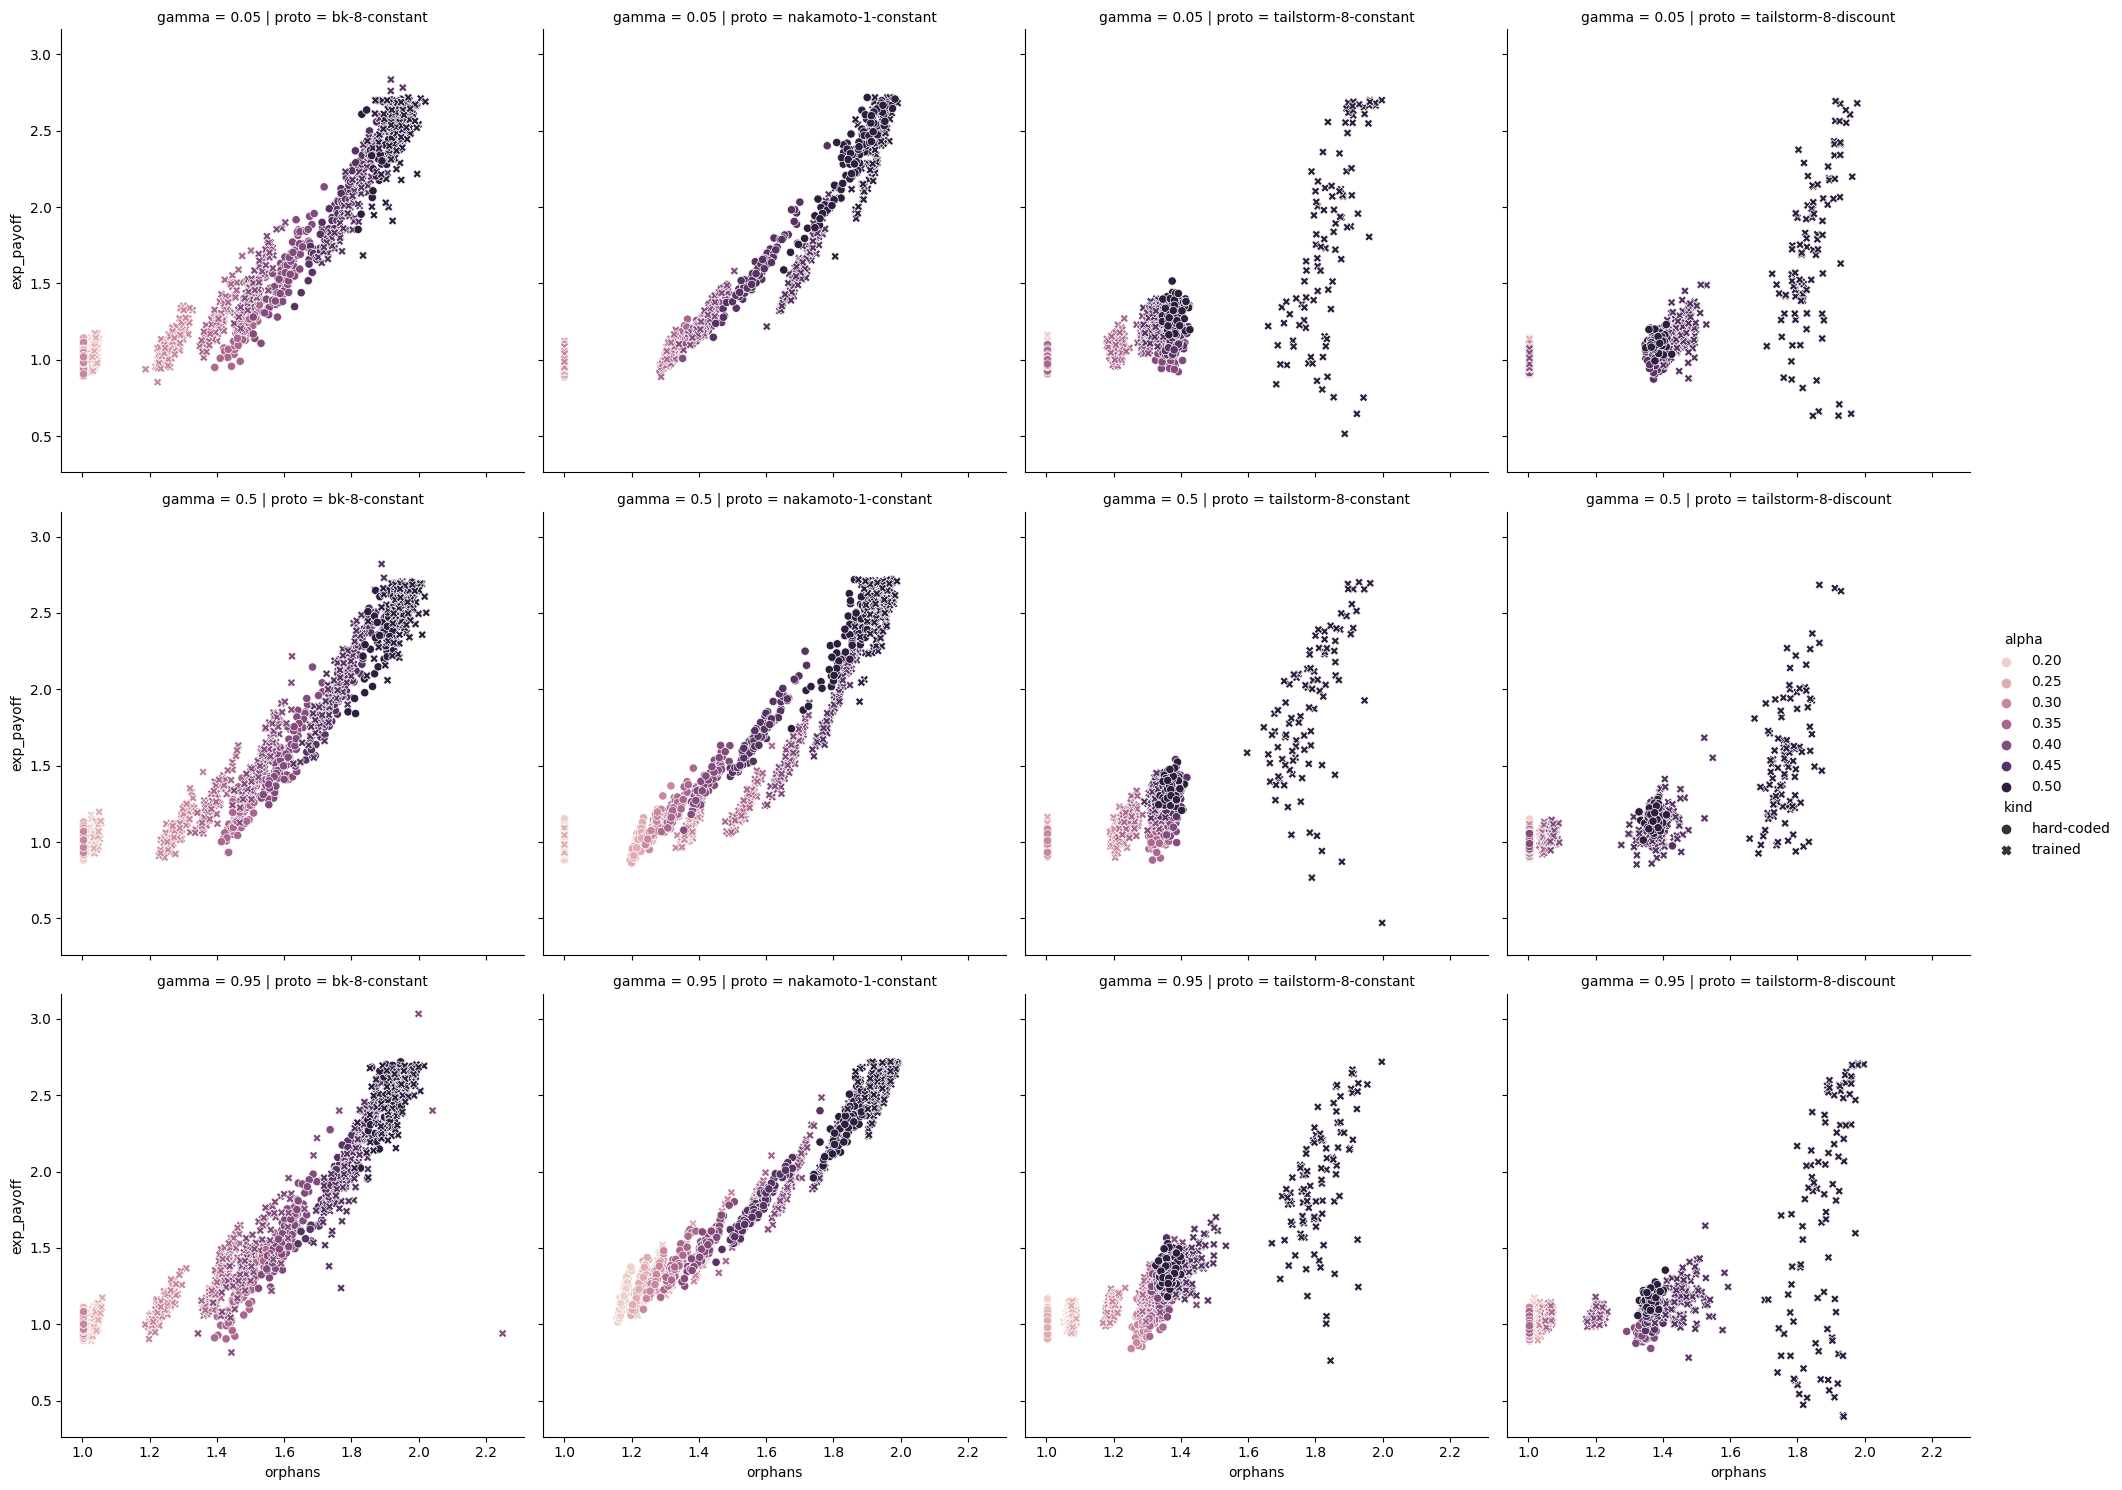

In [16]:
sns.relplot(
    data=d.assign(exp_payoff=np.exp(d.payoff - 1)),
    x="orphans",
    y="exp_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

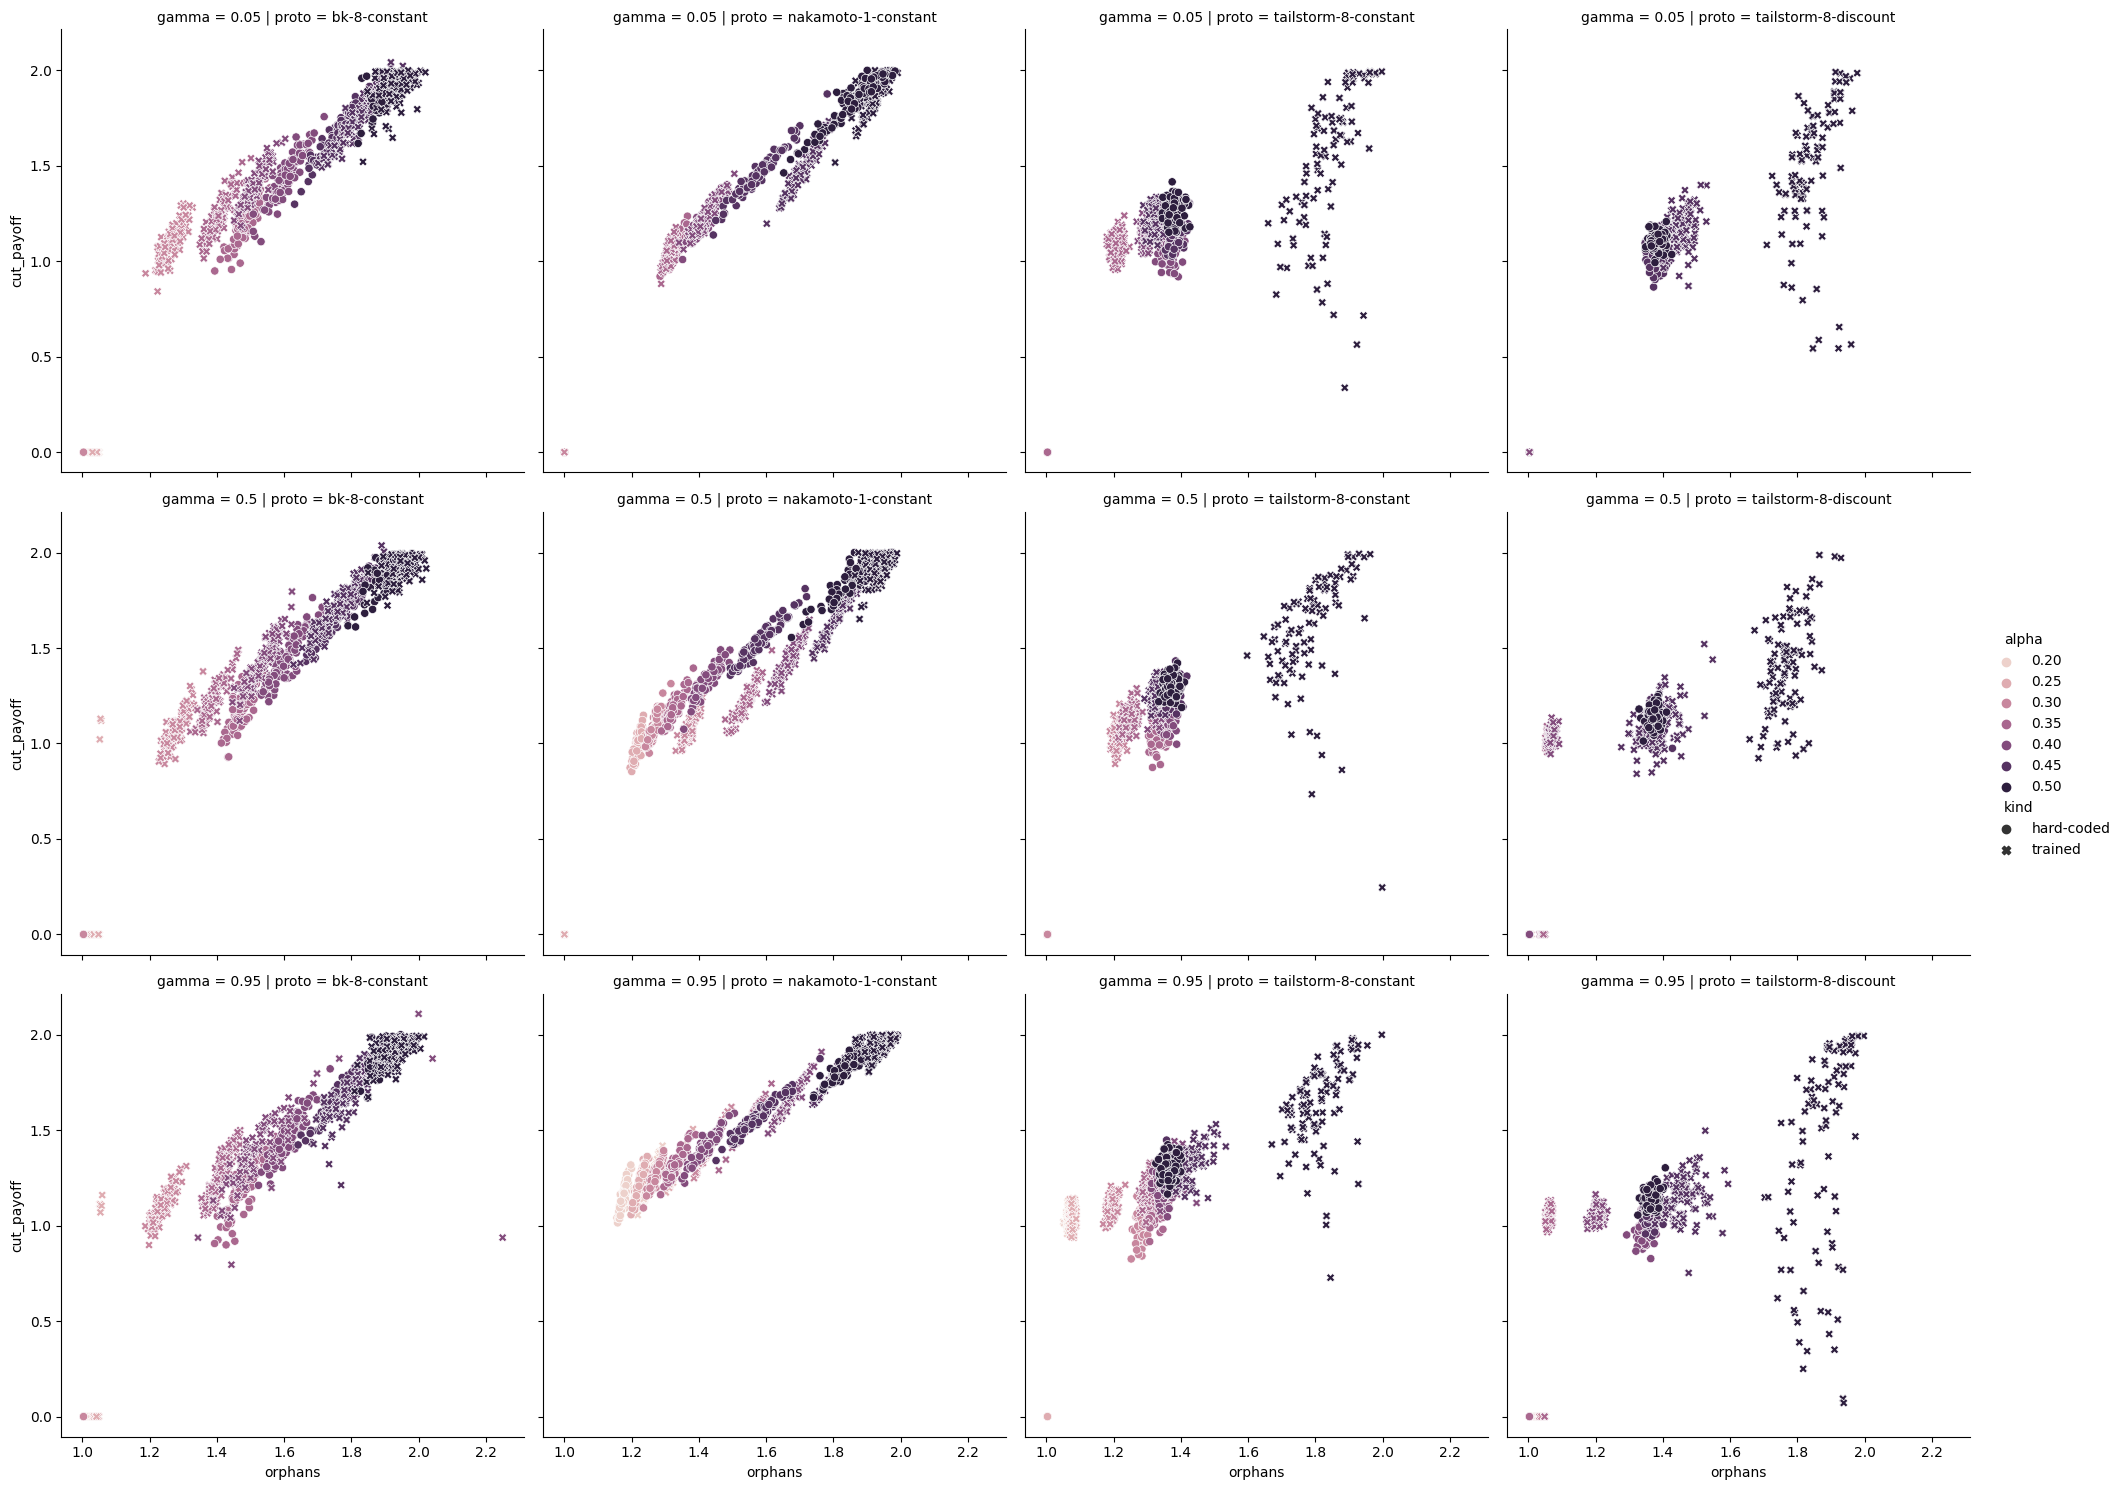

In [17]:
sns.relplot(
    data=d.assign(
        cut_payoff=[x.payoff if x.orphans > 1.05 else 0 for _, x in d.iterrows()]
    ),
    x="orphans",
    y="cut_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

# Break-even point

Per protocol and gamma, we proceed as follows:
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. $P$ should be the first profitable policy after the break-even point
3. derive policy $P_\hat{\alpha}$ from $P$ by hard-wiring $\hat{\alpha}$ in the observation
4. evaluate $P_\hat{\alpha}$ on full range of alphas
    1. set loss funtcion `loss(alpha) = abs(reward_attacker / episode_progress / alpha - 1)`
    2. minimize loss function with Bayesian optimization

In [18]:
grouping = ["protocol", "k", "reward", "subblock_selection", "gamma", "kind"]
select = ["policy", "reused", "path"]
d = honest_or_attack_episodes.query("is_honest == False and reused==False")
d = d[grouping + ["alpha"] + select].drop_duplicates().reset_index(drop=True)
d = d.loc[d.groupby(grouping).alpha.idxmin()].reset_index(drop=True)
be_policies = d
display(be_policies.drop(columns="path"))

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.35   
1          bk  8  constant                n/a   0.05     trained   0.30   
2          bk  8  constant                n/a   0.50  hard-coded   0.35   
3          bk  8  constant                n/a   0.50     trained   0.30   
4          bk  8  constant                n/a   0.95  hard-coded   0.35   
5          bk  8  constant                n/a   0.95     trained   0.30   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.35   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.25   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.35   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.30   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.45   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.40   

                  policy  reused  
0             avoid-loss   False  
1      ppo-7fjmew8i-best   False  
2             avoid-loss   False  
3         ppo-7c1oa4ew_2   False  
4             avoid-loss   False  
5      ppo-nkt6619p-best   False  
6        eyal-sirer-2014   False  
7      ppo-0f15moox-best   False  
8   sapirshtein-2016-sm1   False  
9      ppo-r6stc42z-best   False  
10  sapirshtein-2016-sm1   False  
11        ppo-f7o4jzu1_2   False  
12           minor-delay   False  
13        ppo-ecriukn4_2   False  
14           minor-delay   False  
15     ppo-qajiet4p-best   False  
16           minor-delay   False  
17     ppo-2wq4ya3o-best   False  
18           minor-delay   False  
19     ppo-ybm7bkzg-best   False  
20           minor-delay   False  
21     ppo-xt0ky4z7-best   False  
22           minor-delay   False  
23     ppo-u619xwba-best   False

In [19]:
import break_even


def find_break_even_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = 8192  # quality of each point
    kwargs["n_calls"] = 100  # how many points
    kwargs[
        "title"
    ] = f"{x.protocol}({x.k}, {x.reward}, {x.subblock_selection})  γ={x.gamma}  {x.policy}"
    if x.kind == "trained":
        with warnings.catch_warnings():
            warnings.filterwarnings(
                action="ignore", category=UserWarning, lineno=458
            )  # transition to sb3 v1.7
            res = break_even.find_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = break_even.find_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


# d = be_policies.query("protocol == 'nakamoto'")
# d = be_policies.loc[[2]]

be_points = parallel_measure(be_policies, fun=find_break_even_row)

  0%|          | 0/24 [00:00<?, ?it/s]

In [20]:
# save episode data for re-use in other notebooks
be_points.to_pickle("experiments/rl-eval/be_points.pkl")

In [21]:
be_points.drop(columns=["path", "break_even_png"])

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.35   
1          bk  8  constant                n/a   0.05     trained   0.30   
2          bk  8  constant                n/a   0.50  hard-coded   0.35   
3          bk  8  constant                n/a   0.50     trained   0.30   
4          bk  8  constant                n/a   0.95  hard-coded   0.35   
5          bk  8  constant                n/a   0.95     trained   0.30   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.35   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.25   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.35   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.30   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.45   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.40   

                  policy  reused  break_even  
0             avoid-loss   False    0.304571  
1      ppo-7fjmew8i-best   False    0.251185  
2             avoid-loss   False    0.306318  
3         ppo-7c1oa4ew_2   False    0.267602  
4             avoid-loss   False    0.303266  
5      ppo-nkt6619p-best   False    0.202053  
6        eyal-sirer-2014   False    0.329727  
7      ppo-0f15moox-best   False    0.328231  
8   sapirshtein-2016-sm1   False    0.251748  
9      ppo-r6stc42z-best   False    0.273448  
10  sapirshtein-2016-sm1   False    0.100000  
11        ppo-f7o4jzu1_2   False    0.100000  
12           minor-delay   False    0.375858  
13        ppo-ecriukn4_2   False    0.302859  
14           minor-delay   False    0.327751  
15     ppo-qajiet4p-best   False    0.258628  
16           minor-delay   False    0.287276  
17     ppo-2wq4ya3o-best   False    0.195971  
18           minor-delay   False    0.435967  
19     ppo-ybm7bkzg-best   False    0.399330  
20           minor-delay   False    0.419758  
21     ppo-xt0ky4z7-best   False    0.395151  
22           minor-delay   False    0.387555  
23     ppo-u619xwba-best   False    0.327004

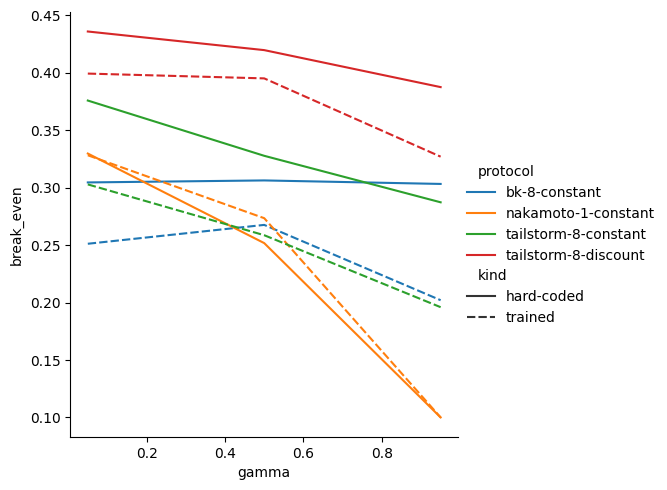

In [22]:
d = be_points.copy()
d.loc[d.reused, "kind"] = "trained/reused"
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    ),
    kind="line",
    hue="protocol",
    x="gamma",
    y="break_even",
    style="kind",
)

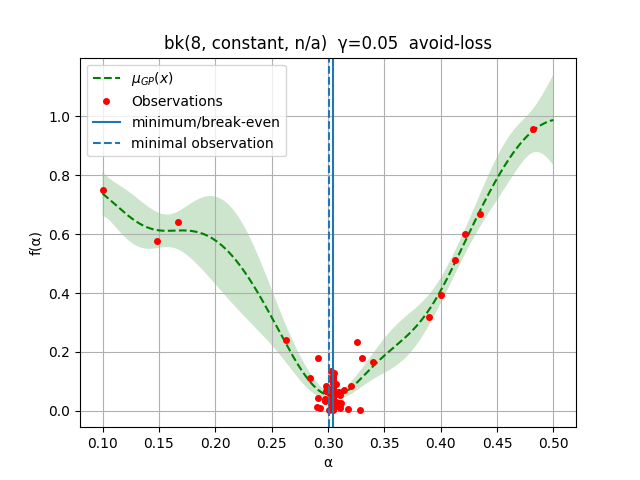

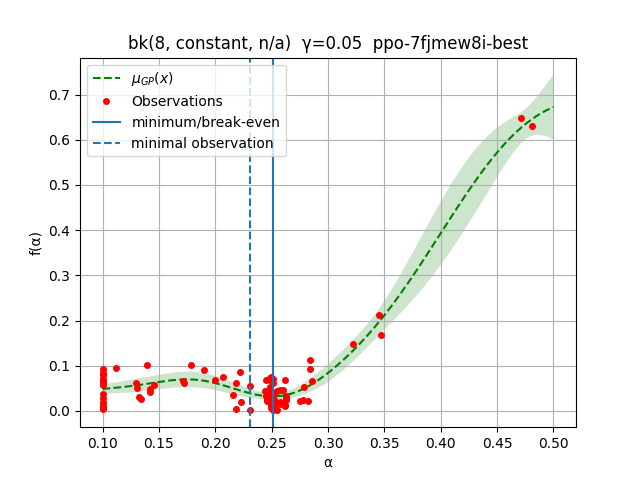

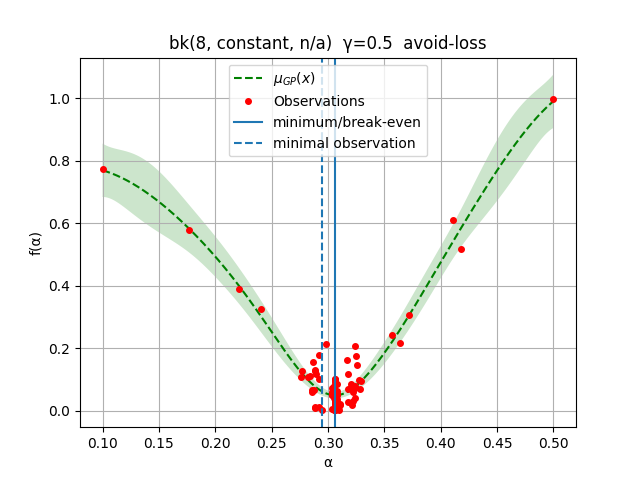

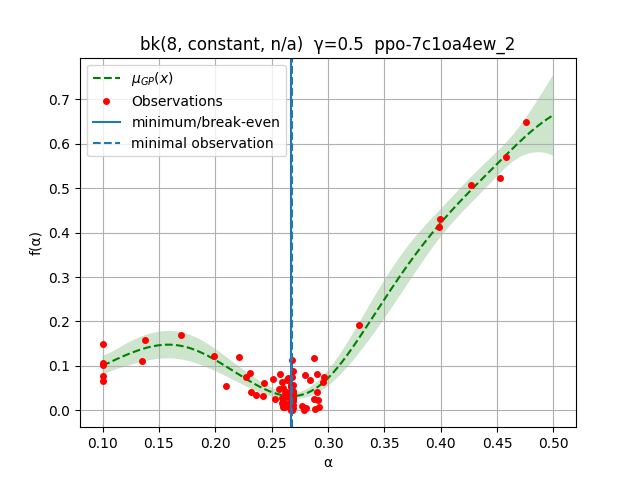

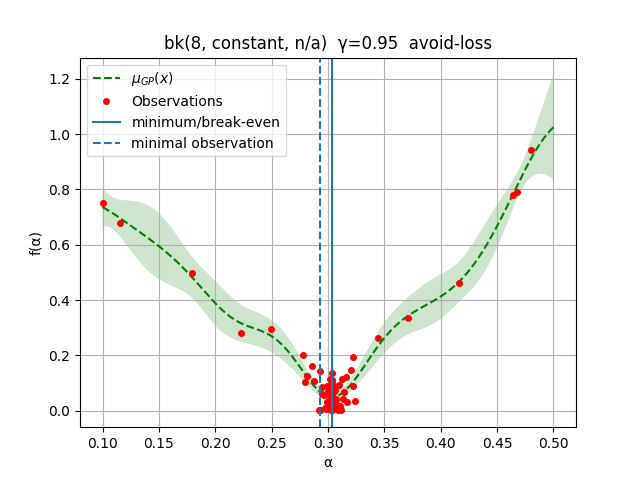

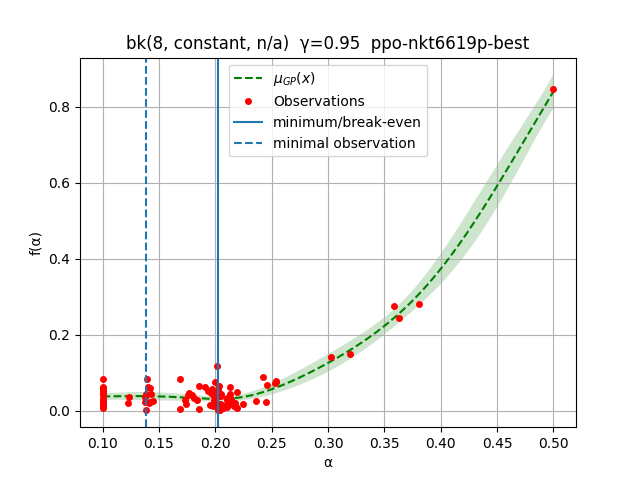

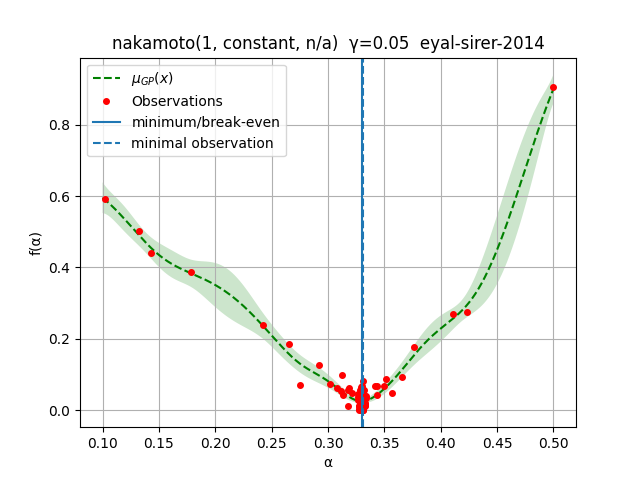

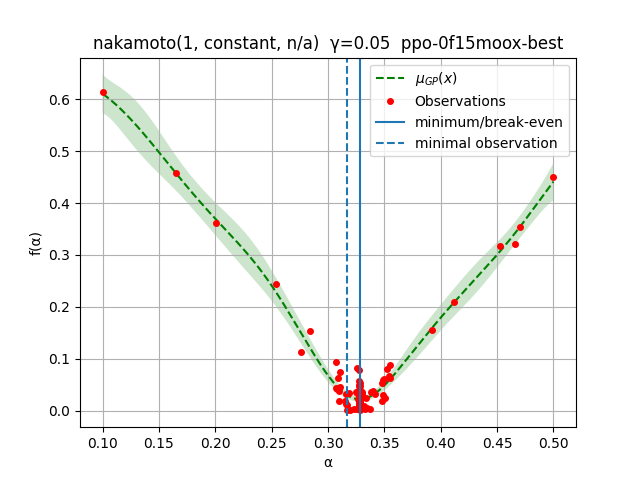

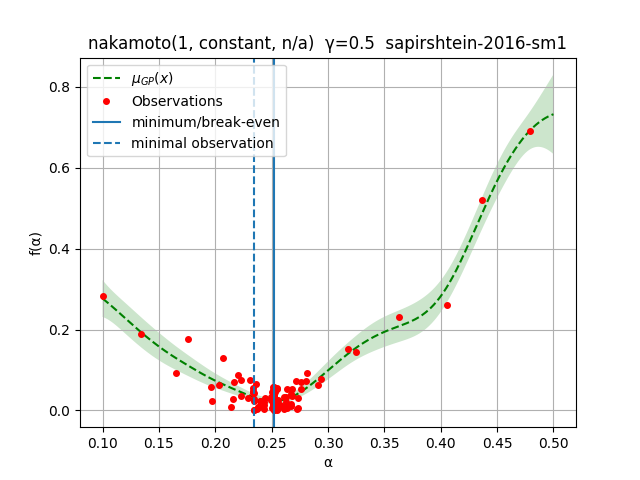

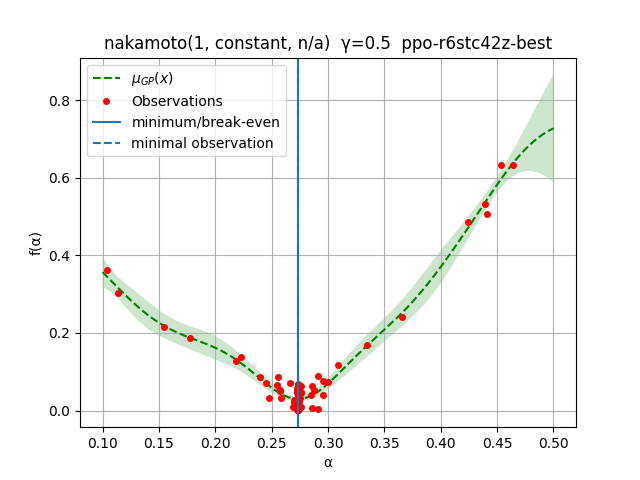

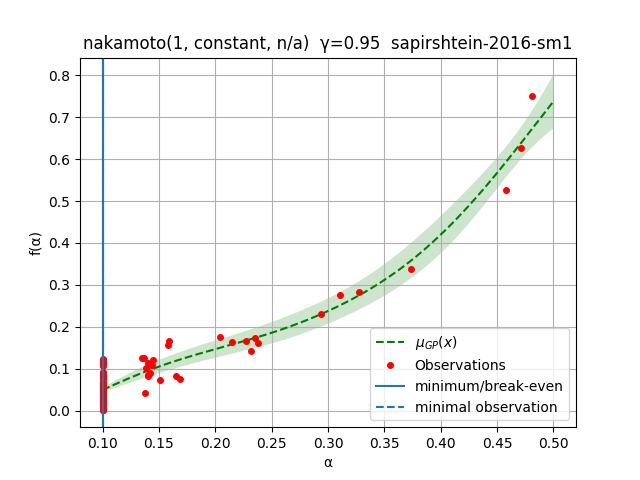

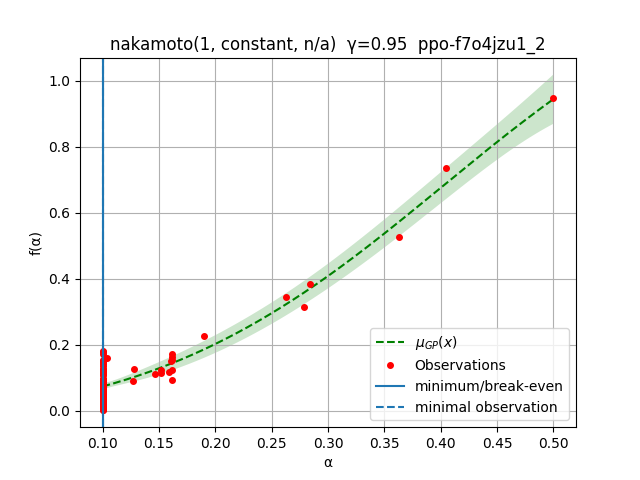

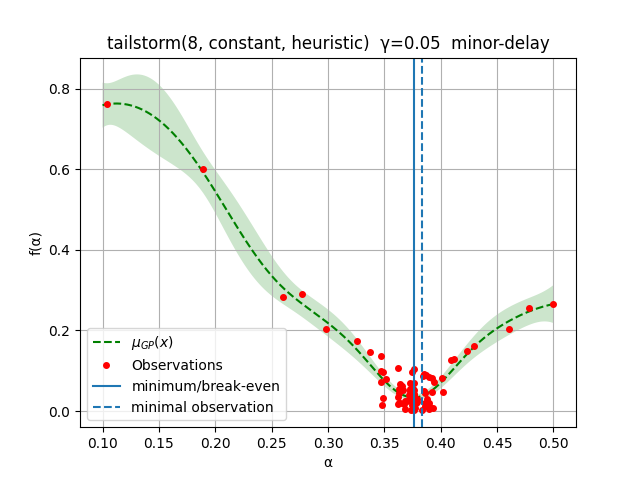

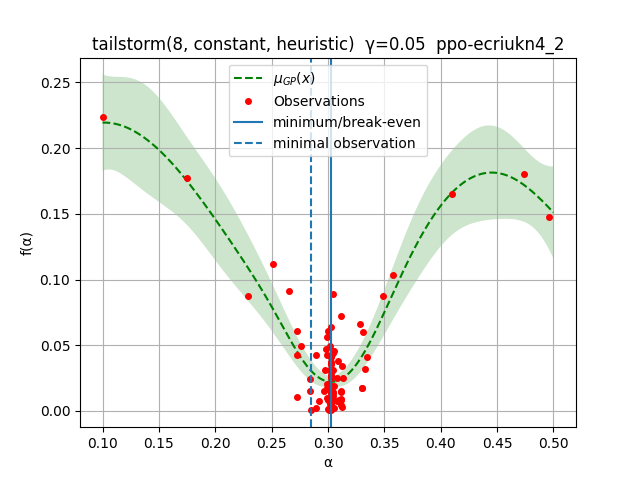

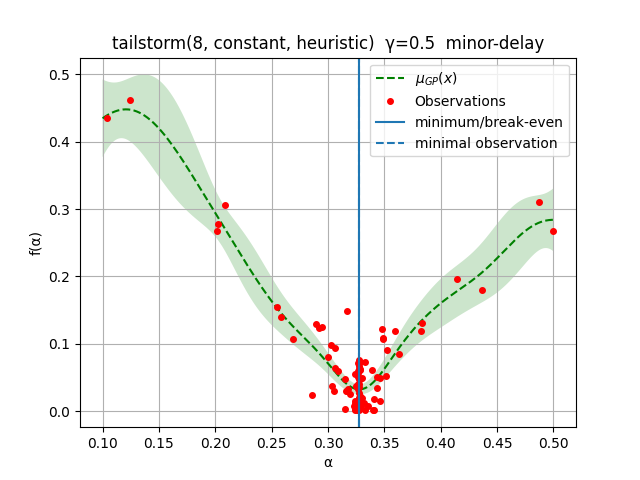

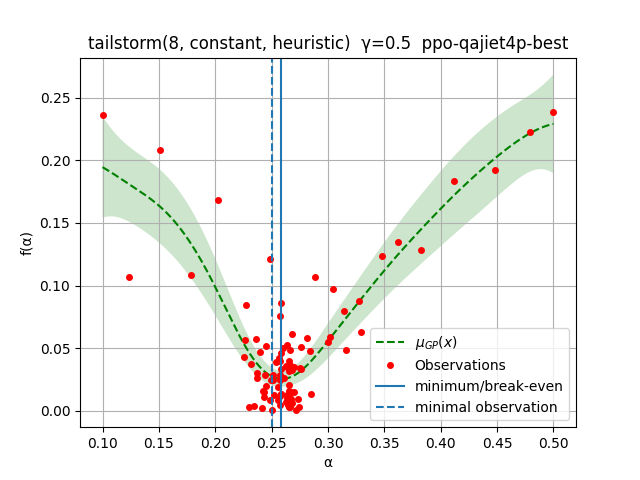

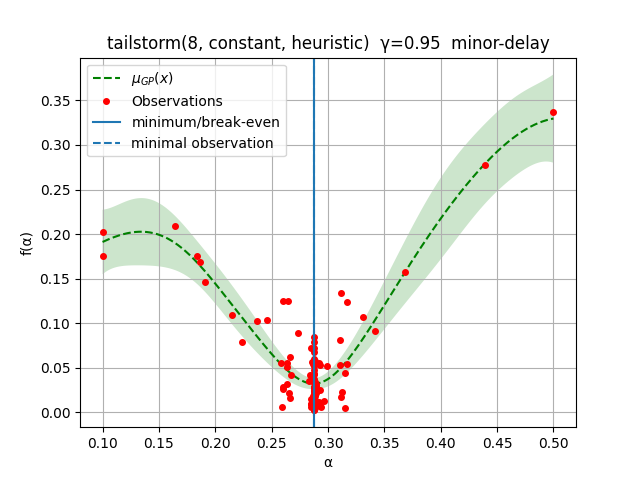

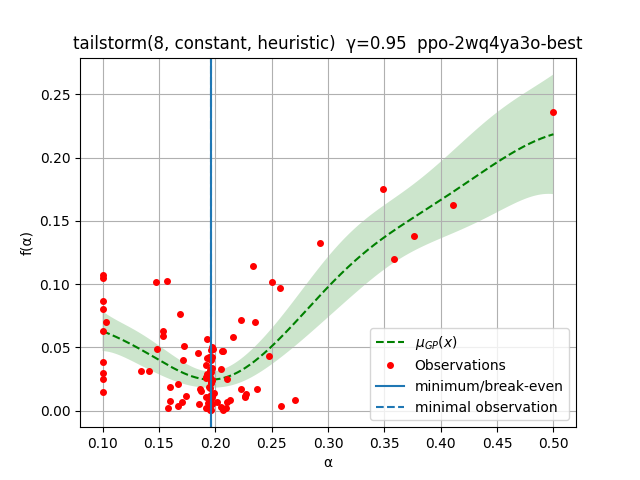

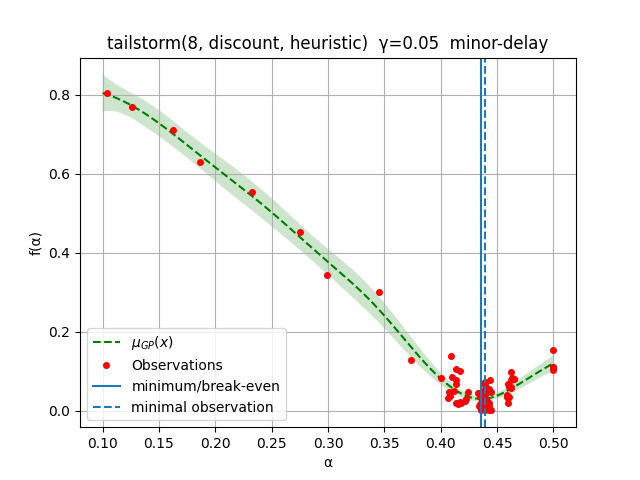

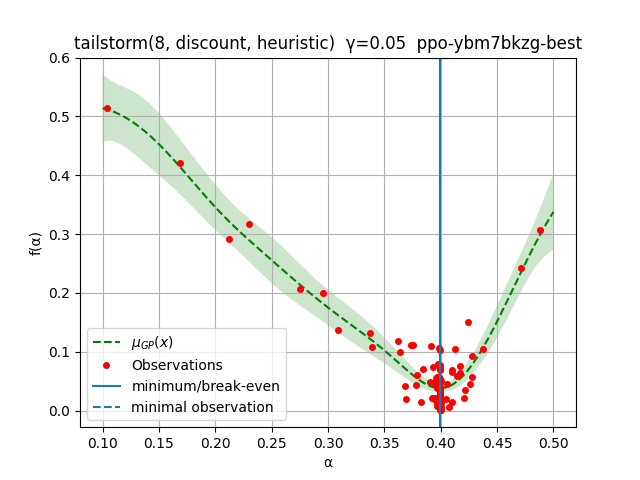

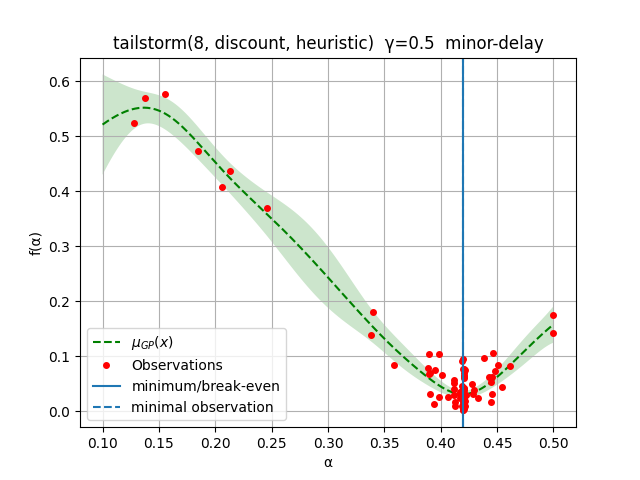

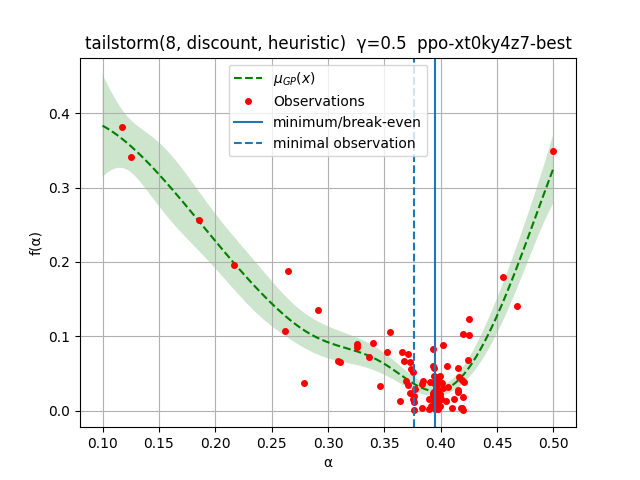

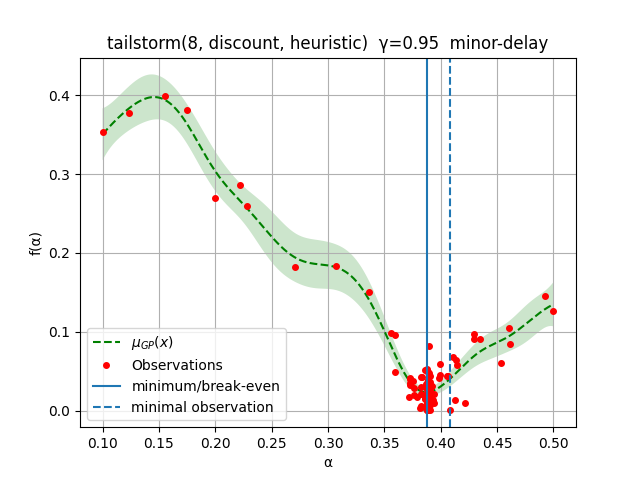

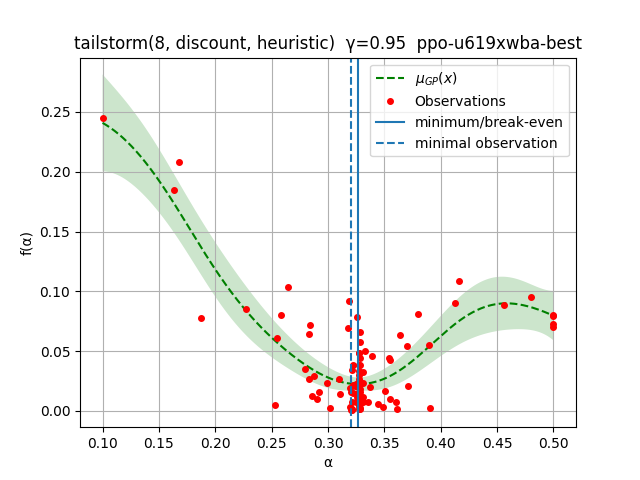

In [23]:
import IPython.display

_ = be_points.break_even_png.apply(
    lambda x: display(IPython.display.Image(data=x, format="png"))
)